## Importations

In [37]:
import scipy.io
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Data visualisation

In [38]:
face = scipy.io.loadmat('face.mat')
print(face.keys())
print(face["l"].shape)
print(face["X"].shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'l'])
(1, 520)
(2576, 520)


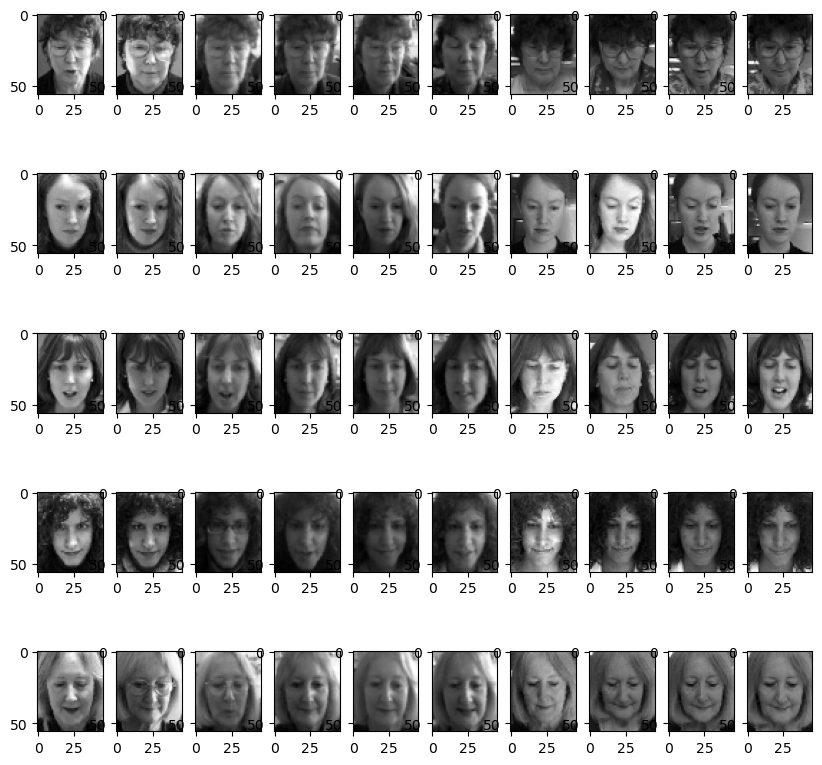

In [39]:
plt.figure(figsize=(10,10))
for i in range(5):
    for j in range(10):
        plt.subplot(5,10,i*10+j+1)

        face_ = face["X"][:,i*10+j].reshape((46,56))

        plt.imshow(face_.T,"gray")

## Data processing

In [40]:
def split_train_test(faces, labels ,nb_per_person,nb_train):

    n, m = faces.shape
    labels = labels.flatten()

    index_train = []
    for i in range(0,m, nb_per_person):

        index_train += list(np.random.choice(nb_per_person,nb_train,replace=False)+i)

    index_test = list(set(np.arange(m)) - set(index_train))
    np.random.shuffle(index_train)
    np.random.shuffle(index_test)

    train_dataset = faces[:,index_train]
    test_dataset = faces[:,index_test]
    label_train_dataset = labels[index_train]
    label_test_dataset = labels[index_test]

    return train_dataset, test_dataset, label_train_dataset, label_test_dataset


In [41]:
train_dataset, test_dataset, label_train_dataset, label_test_dataset = split_train_test(face["X"],face["l"],10,8)


## Q1

### Eigenfaces

#### Mean computing

In [14]:
d, n = train_dataset.shape
vector_mean = np.mean(train_dataset, axis = 1, keepdims=True)
A = train_dataset - vector_mean

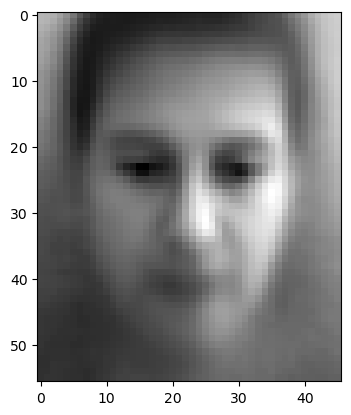

In [15]:
plt.imshow(vector_mean.reshape((46,56)).T,"gray")

The average image represents the average of all the training images and serves as a reference for centring the data. This image is obtained by averaging each pixel across all the training images. It provides a kind of ‘blurred portrait’ that captures the average facial features, which can reveal common facial characteristics in the dataset. By removing these characteristics common to all portraits, we retain only the details that allow us to differentiate between faces.

#### Covariance Matrix

In [16]:

S = (1/n) * A@A.T

#### Eigenvalues and eigenvectors computing

In [17]:
eigenvalues, eigenvectors = np.linalg.eigh(S)
index = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[index]
eigenvectors = eigenvectors[:,index]

#### Eigenvalues and eigenvectors analysis

In [18]:
nb_eigenvalues = np.count_nonzero(eigenvalues > 1e-3)
print(nb_eigenvalues)

415


In our situation, an eigenvalue is considered to be non-zero if it is greater than 10^-3^. Calculating the number of non-zero eigenvalues gives 415. This is consistent since the covariance matrix is of rank N-1 with N = 416 the number of images in the data. The rank corresponding to the number of non-zero eigenvalues is therefore relevant. The rank of the matrix is N-1 because there are N images but a dependency is created between the columns during normalisation. 

<BarContainer object of 2576 artists>

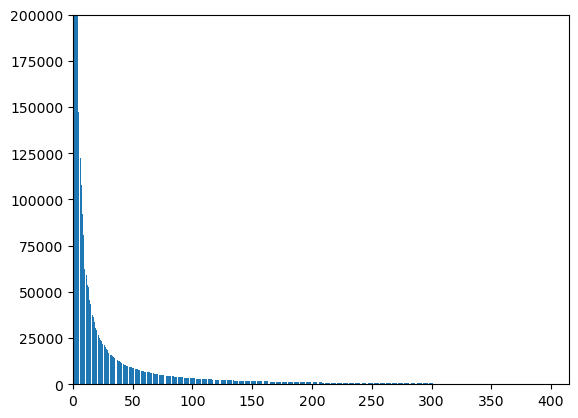

In [19]:
plt.ylim(0,2e5)
plt.xlim(0,nb_eigenvalues)
plt.bar(np.arange(eigenvalues.size), eigenvalues)

Looking at the non-zero eigenvalues, we can see that some vectors have much higher eigenvalues than others. This means that these vectors carry more information. In other words, the direction of these vectors expresses the most information since the eigenvalues represents the norm of the vector. So the projection must be in this direction to maximise the amount of information.

In [20]:
print(eigenvectors.shape)

(2576, 2576)


The eigenvectors of the covariance matrix represent orthogonal directions in image space, oriented according to the characteristic features of the faces. Each of these vectors (or eigenface) can be interpreted as a ‘fundamental feature’ or ‘basic component’ for differentiating faces. The first eigenfaces capture the general characteristics (such as the shape of the face or the dark areas for the eyes or mouth), while the subsequent ones detail more subtle variations.

122


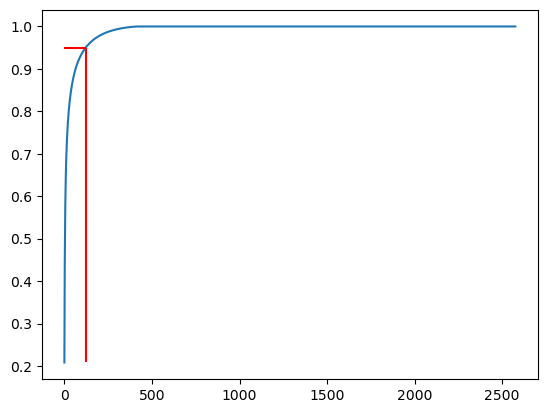

In [21]:
tol = 0.95

info_cum = np.cumsum(eigenvalues)/np.sum(eigenvalues)
M = np.min(np.where(info_cum > tol)[0])
print(M)

plt.plot(info_cum)
plt.vlines(M,np.min(info_cum),tol, color="red")
plt.hlines(tol,0,M, color="red")

In this section, we look at the number of vectors we need to keep in order to maintain 95% of the variance in our projection. To do this, we calculate the cumulative eigenvalues ordered in descending order. Then divide by the sum of the eigenvalues to obtain the ratio of variance explained by the first M vectors. We then look for M such that this ratio is greater than 95%. In our case, M = 165 to explain 95% of the variance.

In [22]:
P = eigenvectors[:,:M]
result = P.T@A

#### PCA 2

In [23]:
S_ = (1/n) * A.T@A

eigenvalues_, eigenvectors_ = np.linalg.eigh(S_)
index_ = np.argsort(eigenvalues_)[::-1]
eigenvalues_ = eigenvalues_[index_]
eigenvectors_ = eigenvectors_[:,index_]

In this situation, we apply the same process as above but with a covariance matrix of the form (1/n)AtA

After following the same process, but this time with the ATA covariance matrix, we see that the eigenvalues and vectors are the same. However, there are a few differences :

|Matrix |   Interpretation| Pros | Cons |
|---------|------------|---|---|
|     AAT    | The AAT form This matrix captures the relationships between pixels across all images, giving a rich representation of covariance in pixel space.     | Direct interpretation in pixel space and gives eigenfaces directly  | High computational cost for large d = W * H |
|     ATA    | This matrix captures the covariance between images themselves, rather than between pixels. It is therefore more compact when the number of images is less than the number of pixels, as is the case here.    | Faster and less expensive calculation when N < d (where N is the number of images and d = W * H). Smaller covariance space  | An additional step is required to obtain the eigenfaces by projecting the eigenvectors of ATA into pixel space. |

### Application of Eigenfaces

In [25]:
def reconstruct_images(projection, images, M):

    images_projected = projection[:,:M].T @ images
    rec_images = projection[:,:M] @ images_projected

    return rec_images

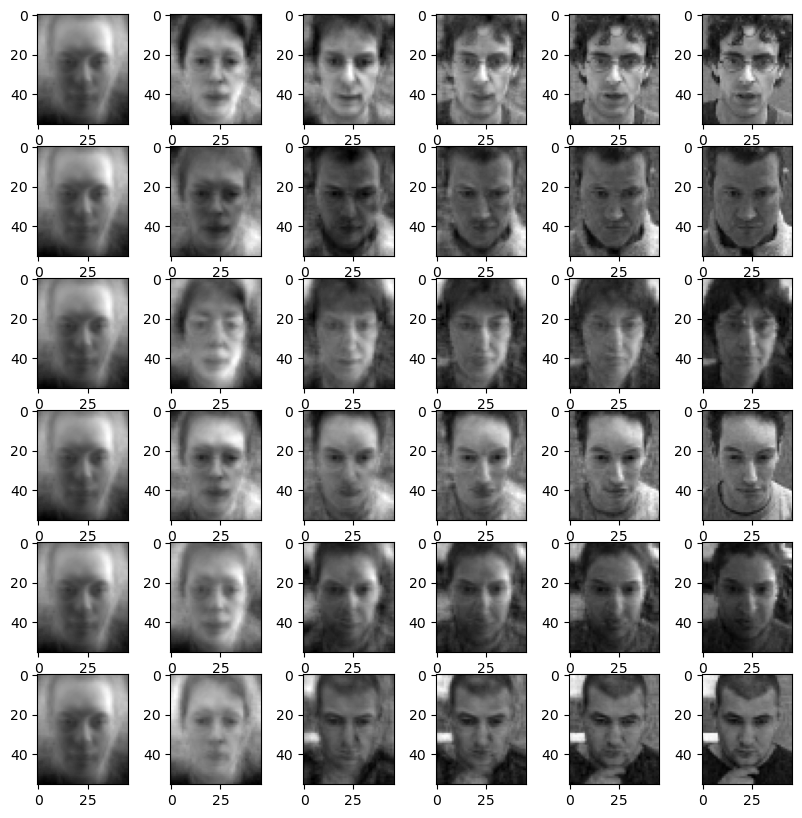

In [26]:
M_values = np.array([1,10,50,100,200,415])
rec_errors_train = np.zeros((6,6))

plt.figure(figsize=(10,10))
for i, M in enumerate(M_values):

    rec_images = reconstruct_images(eigenvectors, train_dataset, M)
    for j in range(6):
        rec_errors_train[j,i] = np.mean((rec_images[:,j] - train_dataset[:,j])**2)

        plt.subplot(6,6,j*6+i+1)
        plt.imshow(rec_images[:,j].reshape((46,56)).T,"gray")

Text(0, 0.5, 'Reconstruction Error')

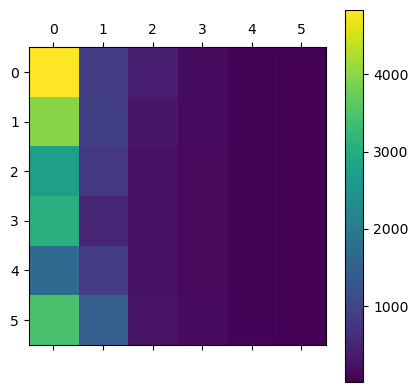

<Figure size 640x480 with 0 Axes>

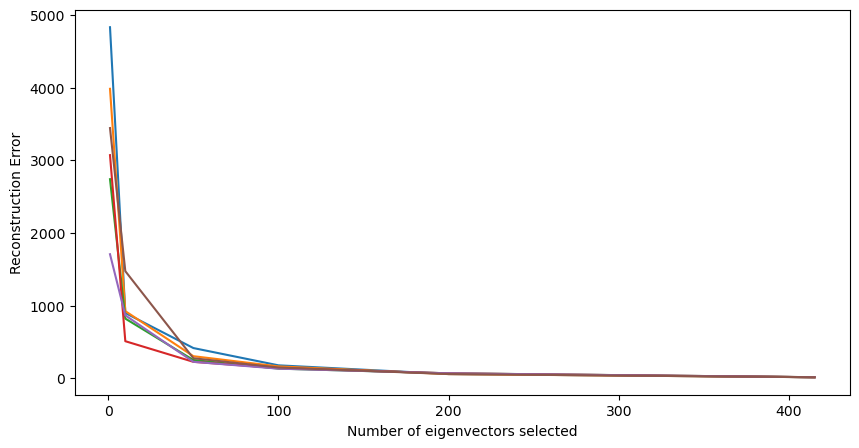

In [28]:
plt.matshow(rec_errors_train)
plt.colorbar()
plt.figure();

plt.figure(figsize=(10,5))
plt.plot(M_values,rec_errors_train.T);
plt.xlabel("Number of eigenvectors selected")
plt.ylabel("Reconstruction Error")


The theory is that the reconstruction is better with a larger number of eigenvectors. This is because the smaller the projection space, the more information is lost when we return to the original space with a larger dimension. This is confirmed in our case. Firstly, a visual analysis shows that for a low number of vectors, the faces are closer to the average face and are completely smooth. On the contrary, as the number of vectors increases, the faces become more detailed as the information is retained. Secondly, we propose to calculate the error matrix. Each line represents an image, and the further to the right you move the higher the number of vectors. This error is calculated in the sense of the MSE. When plotted on a graph, we can see that it decreases as the number of vectors increases. Note that the error decay is much greater when the first vectors are added, as they represent the most information (they are ranked in descending order according to their eigenvalues). On the other hand, the error stabilises for a large number of vectors because they explain less of the variance in the information (low eigenvalues).

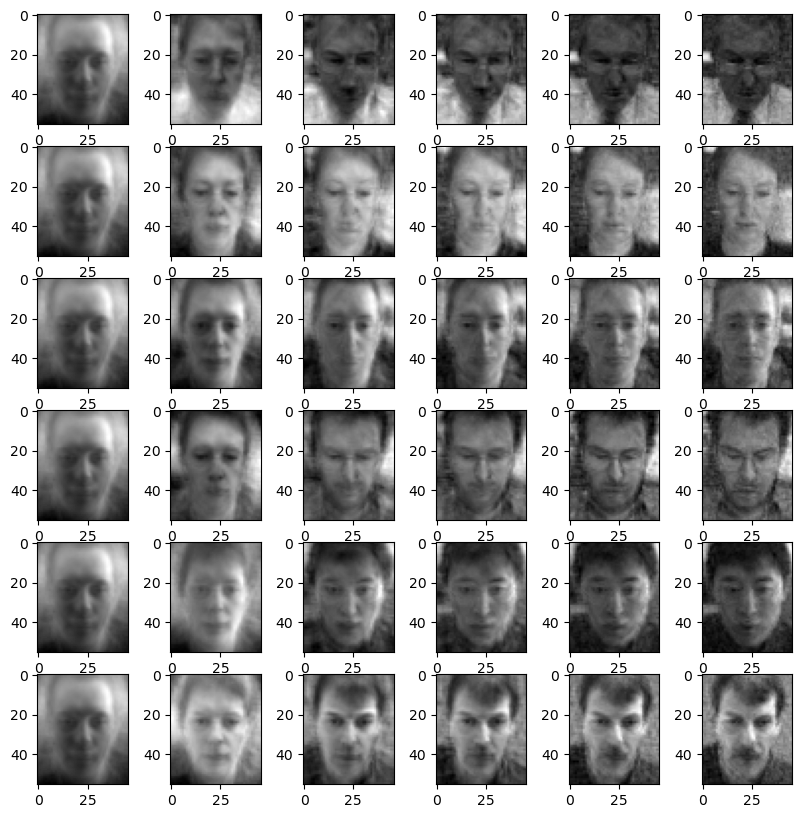

In [243]:
M_values = np.array([1,10,50,100,200,415])
rec_errors_test = np.zeros((6,6))

plt.figure(figsize=(10,10))
for i, M in enumerate(M_values):

    rec_images = reconstruct_images(eigenvectors, test_dataset, M)
    for j in range(6):
        rec_errors_test[j,i] = np.mean((rec_images[:,j] - test_dataset[:,j])**2)

        plt.subplot(6,6,j*6+i+1)
        plt.imshow(rec_images[:,j].reshape((46,56)).T,"gray")

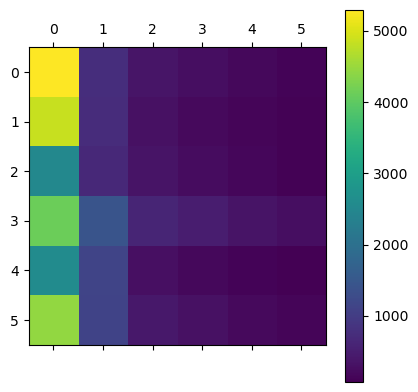

<Figure size 640x480 with 0 Axes>

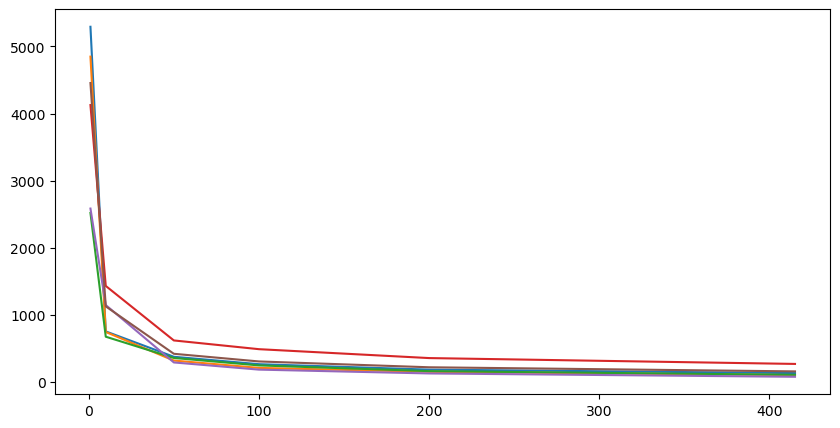

In [244]:
plt.matshow(rec_errors_test)
plt.colorbar()
plt.figure();

plt.figure(figsize=(10,5))
plt.plot(M_values,rec_errors_test.T);

The above comments also apply to images from the test dataset. This time there is also more noise in the reconstruction, which appears to be less effective. This is because the eigenvectors used for projection and reconstruction are not calculated from these images but from similar images. This is why the result remains correct but appears noisy and has a bigger error.

In [46]:
def pca(data,M):

    d, n = data.shape
    vector_mean = np.mean(data, axis = 1, keepdims=True)
    A = data - vector_mean

    S = (1/n) * A@A.T

    eigenvalues, eigenvectors = np.linalg.eigh(S)
    index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:,index]

    P = eigenvectors[:,:M]
    return P, vector_mean

In [52]:
M_values = np.array([1,10,50,100,200,415, 1000, 2000])
accuracy = np.zeros((6,8))

for i, nb_neighbors in enumerate(range(1,7)):

    for j, M in enumerate(M_values):

        P, m = pca(train_dataset,M)
        projected_train = P.T@(train_dataset - m)
        projected_test = P.T@(test_dataset - m)

        neigh = KNeighborsClassifier(n_neighbors=nb_neighbors)
        neigh.fit(projected_train.T, label_train_dataset)
        pred = neigh.predict(projected_test.T)

        accuracy[i,j] = accuracy_score(pred, label_test_dataset)*100

max_parameter = np.unravel_index(np.argmax(accuracy), accuracy.shape)

(0, 5)
68.26923076923077
[[ 4.80769231 46.15384615 66.34615385 67.30769231 67.30769231 68.26923077
  68.26923077 68.26923077]
 [ 3.84615385 36.53846154 51.92307692 50.96153846 53.84615385 53.84615385
  53.84615385 53.84615385]
 [ 5.76923077 41.34615385 49.03846154 51.92307692 50.96153846 52.88461538
  52.88461538 52.88461538]
 [ 6.73076923 41.34615385 50.         50.96153846 51.92307692 51.92307692
  51.92307692 51.92307692]
 [ 4.80769231 36.53846154 48.07692308 49.03846154 51.92307692 50.96153846
  50.96153846 50.96153846]
 [ 5.76923077 31.73076923 50.         49.03846154 49.03846154 47.11538462
  47.11538462 47.11538462]]


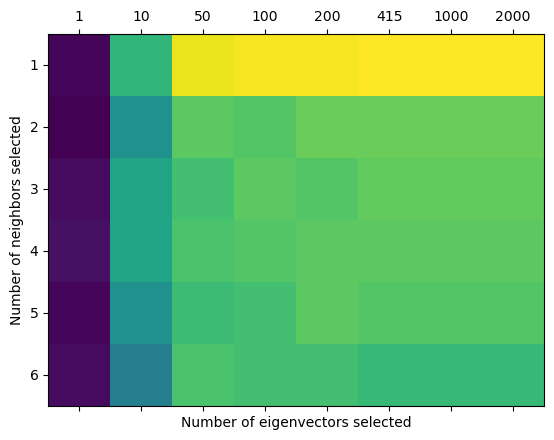

In [58]:
plt.matshow(accuracy)
plt.xlabel("Number of eigenvectors selected")
plt.ylabel("Number of neighbors selected")
plt.xticks(ticks=np.arange(len(M_values)), labels=M_values)
plt.yticks(ticks=np.arange(len(list(range(1,7)))), labels=list(range(1,7)))
print(max_parameter)
print(accuracy[max_parameter[0],max_parameter[1]])
print(accuracy)

Text(0, 0.5, 'Accuracy')

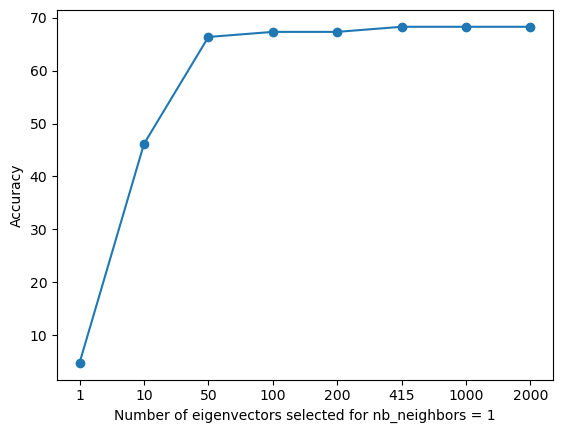

In [64]:
plt.plot(accuracy[0,:],"-o")
plt.xticks(ticks=np.arange(len(M_values)), labels=M_values)
plt.xlabel("Number of eigenvectors selected for nb_neighbors = 1")
plt.ylabel("Accuracy")

In [309]:
def subdivision_4(dataset, label):

    n, m = dataset.shape
    sorted_index = np.argsort(label)
    sorted_dataset = dataset[:,sorted_index]
    sorted_label = label[sorted_index]

    index1 =  np.arange(0,m,4)
    index2 =  np.arange(1,m,4)
    index3 =  np.arange(2,m,4)
    index4 =  np.arange(3,m,4)

    dataset1 = sorted_dataset[index1,:]
    dataset2 = sorted_dataset[index2,:]
    dataset3 = sorted_dataset[index3,:]
    dataset4 = sorted_dataset[index4,:]

    label1 = sorted_label[index1]
    label2 = sorted_label[index2]
    label3 = sorted_label[index3]
    label4 = sorted_label[index4]

    return [dataset1,dataset2,dataset3,dataset4], [label1,label2,label3,label4]

In [315]:
train_subdataset, label_train_subdataset = subdivision_4(train_dataset,label_train_dataset)

In [312]:
def incremental_pca(subdata, M):

    eigenvalues = None
    eigenvectors = None


    for i, subset in enumerate(subdata):

        N2 = subset.shape[1]
        mu2 = np.mean(subset, axis = 1, keepdims= True)

        A = subset - mu2
        S2 = (1/subset.shape[1]) * A@A.T

        if eigenvalues is None:
            mu1 = mu2
            N1 = N2
            S1 = S2

        else:

            N3 = N1 + N2 
            S1 = (N1/N3) * S1 + (N2/N3) * S2 + ((N1*N2)/N3**2)*(mu1-mu2)@(mu1-mu2).T
            mu1 = (N1 * mu1 + N2 * mu2)/N3
            N1 = N3

    eigenvalues, eigenvectors = np.linalg.eigh(S1)
    index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:,index]

    P = eigenvectors[:,:M]
    return P


In [316]:
incremental_pca(train_subdataset,10)

array([[ 0.09031818, -0.05561394,  0.09692704, ...,  0.26430099,
        -0.0379353 ,  0.12820642],
       [ 0.135167  , -0.05443682,  0.12306864, ...,  0.18907386,
         0.08980994,  0.00506423],
       [ 0.15535986, -0.05476486,  0.10256871, ...,  0.04300183,
         0.21043514,  0.06808704],
       ...,
       [ 0.0371776 , -0.0078602 , -0.03285883, ...,  0.13278634,
         0.22451529,  0.09294651],
       [ 0.02659873,  0.00426499, -0.06209583, ...,  0.16522968,
         0.25023377,  0.05989764],
       [ 0.04291037,  0.01438853, -0.07367272, ...,  0.18631271,
         0.19984722, -0.00158133]])

## Q5

In [17]:
train_dataset.shape
label_train_dataset.shape

(416,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# Initialiser les paramètres
params = {
    "n_estimators": [10, 25, 70],  # Nombre d'arbres
    "max_depth": [3, 5, 10],    # Profondeur maximale
    "max_features": [0.03, 0.05, 0.1],  # Nombre de features à considérer pour chaque split
}

# Stocker les résultats
results = []

# Parcourir les combinaisons de paramètres
for n_trees in params["n_estimators"]:
    for depth in params["max_depth"]:
        for features in params["max_features"]:
            # Initialisation du modèle
            rf = RandomForestClassifier(
                n_estimators=n_trees,
                max_depth=depth,
                max_features=features,
                random_state=42
            )

            # Entraîner et mesurer le temps d'entraînement
            start_time = time.time()
            rf.fit(train_dataset.T, label_train_dataset)
            train_time = time.time() - start_time

            # Tester et mesurer le temps de test
            start_time = time.time()
            y_pred = rf.predict(test_dataset.T)
            test_time = time.time() - start_time

            # Calculer l'accuracy et la matrice de confusion
            accuracy = accuracy_score(label_test_dataset, y_pred)
            conf_matrix = confusion_matrix(label_test_dataset, y_pred)

            # Sauvegarder les résultats
            results.append({
                "n_estimators": n_trees,
                "max_depth": depth,
                "max_features": features,
                "train_time": train_time,
                "test_time": test_time,
                "accuracy": accuracy,
                "confusion_matrix": conf_matrix
            })


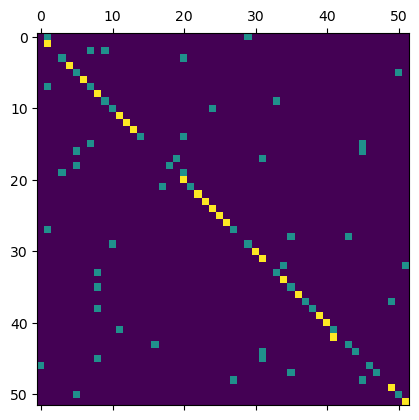

In [29]:
plt.matshow(results[-1]["confusion_matrix"])